# Machine Learning with PyTorch and Scikit-Learn  
# -- Imports

In [4]:

from torch_geometric import utils
from sklearn.preprocessing import StandardScaler
from fastcore.all import *
from copy import deepcopy
import hdbscan
from IPython.display import display
import torch
import copy
import hdbscan
from gh_extraction import *
from fastcore.all import *
from sklearn.preprocessing import OneHotEncoder
from pathlib import Path
import numpy as np
import networkx as nx
from torch_geometric.utils import degree
cfg = 'config.ini'
env = load_create_environment('240402-gnn testing', config=cfg)
GHComponentTable.initialise(env)

guid_to_idx_dict = {id: i for i, id in enumerate(GHComponentTable.df['guid'])}
idx_to_guid_dict = {i: id for i, id in enumerate(GHComponentTable.df['guid'])}
idx_to_name_dict = {idx: ":".join((GHComponentTable.component_dict.get(System.Guid(guid)).Desc.Category, 
                                   GHComponentTable.component_dict.get(System.Guid(guid)).Desc.Name))  for idx, guid in idx_to_guid_dict.items()}


In [42]:
# components = []
# p = None
# # Initialize comp_data before the loop to make it accessible outside.
# comp_data = {}

# for i, id in enumerate(GHComponentTable.df['guid']):
#     prox = GHComponentTable.component_dict.get(System.Guid(id))
#     name = prox.Desc.Name
#     p = prox.CreateInstance()
#     id = str(p.ComponentGuid)
#     # Use the ID to create or update entries in comp_data without reinitializing it.
#     if id not in comp_data:
#         comp_data[id] = {'inputs': [], 'outputs': []}

#     try:
#         p = IGH_Component(p)
#         params = [param for param in p.Params.GetEnumerator()]
#         kinds = [int(prm.Kind) for prm in params]
#         typnames = [prm.TypeName for prm in params]
#         param_properties = list(zip(typnames, kinds))
#         for t, n in param_properties:
#             if n == 2:
#                 comp_data[id]['inputs'].append(t)
#             elif n == 3:
#                 comp_data[id]['outputs'].append(t)
#     except Exception as e:
#         print(f"error {name} with exception {e}")
#         try:
#             p = IGH_Param(p)
#             k = p.TypeName
#             comp_data[id]['inputs'].append(k) # Assuming this was intended to be managed differently.
#             # comp_data[id]['outputs'].append(k) - Removed to prevent duplication in inputs and outputs.
#         except Exception as e:
#             print(f"double error {name} with exception {e}")

# # comp_data is now accessible here, outside the loop.
# print(comp_data)


# Preprocessing

# Create the Graph Loader

In [6]:
class GraphLoader:
    def __init__(self, file_or_folder, supergraph=False, seperate_disconnected=False, n=None):
        self.raw_graphs = self.load_file_or_folder(file_or_folder, n)
        self.graphs = (self.process_supergraph if supergraph else self.process_multiple)(self.raw_graphs, seperate_disconnected)
        
    def __call__(self, *args, **kwargs):
        return self.graphs
    
    def process_supergraph(self, graphs, seperate_disconnected):
        G = nx.DiGraph()
        for g in graphs:
            G.add_nodes_from(g.nodes(data=True))
            G.add_edges_from(g.edges(data=True))
        G.remove_nodes_from(list(nx.isolates(G)))
        return G
    
    def process_multiple(self, graphs, separate_disconnected):
        processed_graphs = []
        for g in graphs:
            if separate_disconnected:
                # For each weakly connected component, create a new graph
                for component in nx.weakly_connected_components(g):
                    new_g = g.subgraph(component).copy()
                    new_g.remove_nodes_from(list(nx.isolates(new_g)))
                    if new_g.number_of_nodes() > 5:  # Ignore empty graphs
                        processed_graphs.append(new_g)
            else:
                # Remove isolates without separating components
                g.remove_nodes_from(list(nx.isolates(g)))
                if g.number_of_nodes() > 5:  # Ignore empty graphs
                    processed_graphs.append(g)
        return processed_graphs
    
        
    def load_file_or_folder(self, path, n):
        np.random.seed(12)
        if isinstance(path, str):
            path = Path(path)
        if path.is_file():
            if path.suffix == '.graphml':
                return [nx.read_graphml(str(path))]
        elif path.is_dir():
            files = globtastic(path, skip_folder_re='ss', file_glob='*.*graphml*')
            if n:
                files = list(np.random.choice(files, n))
            return [nx.read_graphml(file) for file in files]
        else:
            raise ValueError('Path must be a file or a folder')

    def graph_img(G, color_attribute='hbdscan', size_attribute='betweenness', size_scale=10000, show_labels=False):
        fig, ax = plt.subplots(figsize=(20, 12))
    
        # Generate category color map for fallback
        categories = set(nx.get_node_attributes(G, 'category').values())
        category_color_map = {category: plt.cm.tab20c(i) for i, category in enumerate(categories)}
        
        # Check if the color_attribute exists by verifying it in at least one node
        if any(color_attribute in data for _, data in G.nodes(data=True)):
            # Color nodes based on the cluster assignment or other specified attribute
            unique_clusters = set(nx.get_node_attributes(G, color_attribute).values())
            cluster_color_map = {cluster: plt.cm.tab20c(i % 20) for i, cluster in enumerate(unique_clusters)}
            node_colors = [cluster_color_map.get(G.nodes[node].get(color_attribute, None), 'grey') for node in G.nodes()]
    
            # Create a legend for the clusters
            legend_handles = [Patch(color=color, label=f"Cluster {cluster}") for cluster, color in cluster_color_map.items() if cluster != -1]  # Exclude noise if present
            legend_handles.append(Patch(color='grey', label='Noise or unclustered'))  # For HDBSCAN noise or unclustered nodes
        else:
            # Fallback to category colors if color_attribute is not found
            node_colors = [category_color_map.get(G.nodes[node]['category'], 'grey') for node in G.nodes()]
    
            # Create a legend for the categories
            legend_handles = [Patch(color=color, label=category) for category, color in category_color_map.items()]
        
        ax.legend(handles=legend_handles, title='Categories or Clusters', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)
    
        # Retrieve the specified attribute for node sizes, scaled for visualization
        node_sizes = [G.nodes[node].get(size_attribute, 0.1) * size_scale for node in G.nodes()]  # Default size if attribute missing
    
        # Construct pos dictionary using x and y attributes from nodes
        pos = {node: (G.nodes[node]['x'], G.nodes[node]['y']) for node in G.nodes()}
    
        # Draw the graph
        nx.draw(G, pos, with_labels=show_labels, node_color=node_colors, node_size=node_sizes, edge_color="dimgray", linewidths=0.000, font_size=12, ax=ax, arrowsize=1)
    
        plt.show()
        
    
    def __getitem__(self, index):
        return self.graphs[index]

    
    def __len__(self):
        return len(self.graphs)

    
def compute_and_assign_centralities(G, compute_degree=False, compute_closeness=False, compute_betweenness=False, compute_in_out_degree=False,
                                    compute_clustering=False, compute_hdbscan=False, hdbscan_min_cluster_size=5, **kwargs):
    # Create a deep copy of G to not alter the original graph
    G_transformed = copy.deepcopy(G)
    
    if compute_degree:
        degree_centrality = nx.degree_centrality(G_transformed)
        nx.set_node_attributes(G_transformed, degree_centrality, 'degree')
    
    if compute_closeness:
        closeness_centrality = nx.closeness_centrality(G_transformed)
        nx.set_node_attributes(G_transformed, closeness_centrality, 'closeness')
    
    if compute_betweenness:
        betweenness_centrality = nx.betweenness_centrality(G_transformed)
        nx.set_node_attributes(G_transformed, betweenness_centrality, 'betweenness')
    
    if compute_clustering:
        clustering_coefficient = nx.clustering(G_transformed)
        nx.set_node_attributes(G_transformed, clustering_coefficient, 'clustering')

    if compute_in_out_degree:
        in_degree_centrality = nx.in_degree_centrality(G_transformed)
        out_degree_centrality = nx.out_degree_centrality(G_transformed)
        nx.set_node_attributes(G_transformed, in_degree_centrality, 'indegree')
        nx.set_node_attributes(G_transformed, out_degree_centrality, 'outdegree')
        
    if compute_hdbscan:
        # Extract node positions
        positions = np.array([(G_transformed.nodes[node]['x'], G_transformed.nodes[node]['y']) for node in G_transformed.nodes()])
        
        # Apply HDBSCAN on spatial coordinates
        hdbscan_kwargs = {k: v for k, v in kwargs.items() if k.startswith('hdbscan_')}
        clustering = hdbscan.HDBSCAN(min_cluster_size=hdbscan_min_cluster_size, **hdbscan_kwargs).fit(positions)
        
        # Assign cluster labels to nodes
        for node, label in zip(G_transformed.nodes(), clustering.labels_):
            G_transformed.nodes[node]['hdbscan'] = label

    return G_transformed



# load the graphs
location = Path(env.dirs['graphml'])
graphs = GraphLoader(location, supergraph=False, seperate_disconnected=True)
# Compute and assign centralities to the graphs
# graphs = [compute_and_assign_centralities(g, compute_betweenness=True, compute_in_out_degree=True) for g in graphs]
data = [utils.from_networkx(g) for g in graphs]
data

[Data(x=[61], edge_index=[2, 73], y=[61], compid=[61], category=[61], distance=[73], s_paramidx=[73], r_paramidx=[73], s_access=[73], r_access=[73], s_datamapping=[73], r_datamapping=[73], s_is_optional=[73], r_is_optional=[73]),
 Data(x=[85], edge_index=[2, 99], y=[85], compid=[85], category=[85], distance=[99], s_paramidx=[99], r_paramidx=[99], s_access=[99], r_access=[99], s_datamapping=[99], r_datamapping=[99], s_is_optional=[99], r_is_optional=[99]),
 Data(x=[2541], edge_index=[2, 3426], y=[2541], compid=[2541], category=[2541], distance=[3426], s_paramidx=[3426], r_paramidx=[3426], s_access=[3426], r_access=[3426], s_datamapping=[3426], r_datamapping=[3426], s_is_optional=[3426], r_is_optional=[3426]),
 Data(x=[2897], edge_index=[2, 3932], y=[2897], compid=[2897], category=[2897], distance=[3932], s_paramidx=[3932], r_paramidx=[3932], s_access=[3932], r_access=[3932], s_datamapping=[3932], r_datamapping=[3932], s_is_optional=[3932], r_is_optional=[3932]),
 Data(x=[10], edge_index

# Data Preprocessing

In [87]:
import re
from collections import Counter
def matcher(text):
    pattern = r"'(.*?)'"
    matches = re.findall(pattern, text)
    return matches

inparams = [m for d in GHComponentTable.df['paramin'] for m in matcher(d)]
outparams = [m for d in GHComponentTable.df['paramout'] for m in matcher(d)]
param_set = set(inparams+outparams)
param_idx_lookups = {k:i for i, k in enumerate(list(Counter(inparams + outparams).keys()))}
param_idx_lookups_rev = {i: k for i, k in param_idx_lookups.items()}
cat_set = set([element for element in GHComponentTable.df['category']]) 
cat_idx_lookups = {k: i for i, k in enumerate(sorted(cat_set))}
cat_idx_lookups_rev = {i: k for i, k in cat_idx_lookups.items()}
def get_parameter_categories(split_inputs_and_outputs = False):
    if not split_inputs_and_outputs:
        guid_to_param_cat_index = {
            row['guid']: [
                cat_idx_lookups[row['category']],
                [
                    param_idx_lookups[pin]
                    for pin in matcher(row['paramin'])
                ] + [
                    param_idx_lookups[pin]
                    for pin in matcher(row['paramout'])
                ]
            ]
            for _, row in GHComponentTable.df.iterrows()}   
        return guid_to_param_cat_index
    else:
        guid_to_param_cat_index = {
            row['guid']: [
                cat_idx_lookups[row['category']],
                [
                    param_idx_lookups[pin]
                    for pin in matcher(row['paramin'])
                ], 
                [
                    param_idx_lookups[pin]
                    for pin in matcher(row['paramout'])
                ]
            ]
            for _, row in GHComponentTable.df.iterrows()}   
        return guid_to_param_cat_index

guid_to_param_cat_index = get_parameter_categories(True)
print(guid_to_param_cat_index)
ohe_cat = OneHotEncoder(categories=[range(len(cat_set))])
ohe_params = OneHotEncoder(categories=[range(len(param_set))])
guid_to_param_feature={}
guid_to_param_feature = {}
for guid, (cat, ins, outs) in guid_to_param_cat_index.items():
    cat_encoding = torch.from_numpy(ohe_cat.fit_transform(np.array(cat).reshape(-1, 1)).toarray()).squeeze()
    if ins:
        in_encoding = np.zeros((1,len(param_set)))
        in_encoding[0, ins] = 1
        in_encoding = torch.from_numpy(in_encoding).squeeze()
    else:
        in_encoding = torch.zeros((1, len(param_set))).squeeze()
    if outs:
        out_encoding = np.zeros((1, len(param_set)))
        out_encoding[0, outs] = 1
        out_encoding = torch.from_numpy(out_encoding).squeeze()
    else:
        out_encoding = torch.zeros((1, len(param_set))).squeeze()
    
    guid_to_param_feature[guid] = torch.cat([cat_encoding, in_encoding, out_encoding])



        


{'d541404d-b806-453e-8351-a954e824ed22': [34, [0, 1], [2, 2]], 'afff17ed-5975-460b-9883-525ae0677088': [4, [2], [6, 4]], '6b021f56-b194-4210-b9a1-6cef3b7d0848': [4, [3, 4, 5], [6, 16, 4]], '323f3245-af49-4489-8677-7a2c73664077': [4, [3], [5, 5]], 'f2030fa9-db3f-437e-9b50-5607db6daf87': [4, [3], [5]], '424eb433-2b3a-4859-beaf-804d8af0afd7': [4, [3], [6, 4, 4]], 'd7df7658-e02d-4a48-a345-2195a68db4ef': [4, [3], [6, 4]], '66d2a68e-2f1d-43d2-a53b-c6a4d17e627b': [4, [3], [3, 6]], '2dc44b22-b1dd-460a-a704-6462d6e91096': [4, [6, 3], [6, 4, 4]], 'aaa665bd-fd6e-4ccb-8d2c-c5b33072125d': [4, [3, 4], [6, 16, 3]], 'a583f722-240a-4fc9-aa1d-021720a4516a': [4, [3, 4, 4], [4, 4, 4, 4]], 'ab14760f-87a6-462e-b481-4a2c26a9a0d7': [4, [3, 4], [6, 16]], 'c2e16ca3-9508-4fa4-aeb3-0b1f0ebb72e3': [4, [3, 4, 7], [6, 16]], '269eaa85-9997-4d77-a9ba-4c58cb45c9d3': [4, [3, 7], [6, 4]], 'ccfd6ba8-ecb1-44df-a47e-08126a653c51': [4, [3, 8], [3, 8]], '15ac45a8-b190-420a-bd66-e78ed6bcfaa4': [4, [3], [8]], 'ebd6c758-19ae-4d7

{'d541404d-b806-453e-8351-a954e824ed22': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [93]:
from torch_geometric.data import Dataset, DataLoader
from collections import Counter
from collections import OrderedDict

#count the number of occurances of each of the components to cull those whose frequency is below a certain threshold
all_components = torch.tensor([guid_to_idx_dict.get(id_) for d in data for id_ in d['compid']])
all_components_counts = {k: count for k, count in Counter([x.item() for x in all_components]).items()}
ordict = OrderedDict(sorted(all_components_counts.items(), key=lambda x: x[1], reverse=True))
threshold = 1
ones = [k for k, v in ordict.items() if v > threshold]
# this is the dictionary used for one hot encoding. if the component is not in this dictionary then it will return a 0
valid_components_dict = {idx_to_guid_dict[k]: k  for k in ones}






def trnsfrm_positions(data):
    x_ = StandardScaler().fit_transform(np.array(data['x']).reshape(-1, 1))
    y_ = StandardScaler().fit_transform(np.array(data['y']).reshape(-1, 1))
    data['x'] = torch.tensor(np.concatenate([x_, y_], axis=1), dtype=torch.float32)
    param_features = torch.stack([guid_to_param_feature.get(d) for d in data['compid']])
    data['x'] = torch.cat([data['x'], param_features], dim=1)


def trnsfm_compid(data):
    assert data['x'] is not None, 'Please run trnsfrm_positions first'
    data['y'] = torch.tensor([valid_components_dict.get(ids, 0) for ids in data['compid']])
    ohe = OneHotEncoder(categories=[range(len(valid_components_dict.values()))], handle_unknown='ignore')

    data['y'] = torch.tensor(ohe.fit_transform(data['y'].reshape(-1, 1)).toarray())
    return data

def trnsform_edges(data):
    if type(data) == np.array:
        data = torch.tensor(data.toarray())
    t = torch.concat([torch.from_numpy(data[x]) for x in ['s_paramidx', 'r_paramidx', 's_access', 'r_access', 's_datamapping', 'r_datamapping']], dim=1)
    return t
    
def trnsfrm_paramidx(data):
    ohe = OneHotEncoder(categories=[range(11)], handle_unknown='ignore')
    p_in = ohe.fit_transform(np.array(data['s_paramidx'].reshape(-1, 1)))
    p_out = ohe.fit_transform(np.array(data['r_paramidx'].reshape(-1, 1)))
    data['s_paramidx'] = p_in.toarray()
    data['r_paramidx'] = p_out.toarray()

def trnsfrm_access(data):
    ohe = OneHotEncoder(categories=[range(3)], handle_unknown='ignore')
    s_access = ohe.fit_transform(np.array(data['s_access'].reshape(-1, 1)))
    r_access = ohe.fit_transform(np.array(data['r_access'].reshape(-1, 1)))
    data['s_access'] = s_access.toarray()
    data['r_access'] = r_access.toarray()

def trnsfrm_datamapping(data):
    ohe = OneHotEncoder(categories=[range(3)], handle_unknown='ignore')
    s_datamapping = ohe.fit_transform(np.array(data['s_datamapping'].reshape(-1, 1)))
    r_datamapping = ohe.fit_transform(np.array(data['r_datamapping'].reshape(-1, 1)))
    data['s_datamapping'] = s_datamapping.toarray()
    data['r_datamapping'] = r_datamapping.toarray()
    
def trsnfrm_dist(data):
    scaler = StandardScaler()
    data['distance'] = scaler.fit_transform(np.array(data['distance']).reshape(-1, 1))

    
def processX(data):
    std = {'x', 'edge_index', 'y', 'edge_features'}
    for feature in data.keys():
        if feature in std:
            continue
        if data[feature].shape[0] == data['x'].shape[0]:
            # apply scaler
            if feature not in {'in_degree_centrality', 'out_degree_centrality'}:
                StandardScaler().fit_transform(np.array(data[feature]).reshape(-1, 1))
            data['x']=torch.cat([data['x'], data[feature].unsqueeze(-1)], dim=1)
            del data[feature]
    
def trnsfrm(data, rmv_categories= None):
    if rmv_categories is None:
        rmv_categories = ['compid', 's_paramidx', 'r_paramidx', 's_access', 'r_access', 's_datamapping', 'r_datamapping', 'distance', 'r_is_optional', 's_is_optional', 'category']
    data_ = deepcopy(data)

    num_nodes = len(data['category'])

    trnsfrm_positions(data_)
    trnsfm_compid(data_)
    trnsfrm_paramidx(data_)
    trnsfrm_access(data_)
    trnsfrm_datamapping(data_)
    trsnfrm_dist(data_)
    data_['edge_features'] = trnsform_edges(data_)
    for ftr in rmv_categories:
        del data_[ftr]
    
    processX(data_)
    
    processed_data = create_masks_for_each_graph(data_)
    return processed_data

def process_dataset(data_list):
    # Process and apply masks to each graph individually
    return [trnsfrm(data) for data in data_list]

def create_masks_for_each_graph(data, train_ratio=0.7, val_ratio=0.2):
    num_nodes = data['x'].shape[0]  # Assuming 'x' is node features matrix
    perm = torch.randperm(num_nodes)
    train_end = int(num_nodes * train_ratio)
    val_end = train_end + int(num_nodes * val_ratio)

    # Initialize masks
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    # Assign masks
    train_mask[perm[:train_end]] = True
    val_mask[perm[train_end:val_end]] = True
    test_mask[perm[val_end:]] = True

    # Update the data dictionary with masks
    data['train_mask'] = train_mask
    data['val_mask'] = val_mask
    data['test_mask'] = test_mask
    return data


class GraphDataset(Dataset):
    def __init__(self, data_list):
        super(GraphDataset, self).__init__()
        self.data_list = data_list
         
 
    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

ds = process_dataset(data)
dataset = GraphDataset(ds)

save_location = f"{env.dirs['csv'] / '240328-dataset'}"
# torch.save(dataset, save_location)

In [94]:
ds


[Data(x=[61, 270], edge_index=[2, 73], y=[61, 772], edge_features=[73, 34], train_mask=[61], val_mask=[61], test_mask=[61]),
 Data(x=[85, 270], edge_index=[2, 99], y=[85, 772], edge_features=[99, 34], train_mask=[85], val_mask=[85], test_mask=[85]),
 Data(x=[2541, 270], edge_index=[2, 3426], y=[2541, 772], edge_features=[3426, 34], train_mask=[2541], val_mask=[2541], test_mask=[2541]),
 Data(x=[2897, 270], edge_index=[2, 3932], y=[2897, 772], edge_features=[3932, 34], train_mask=[2897], val_mask=[2897], test_mask=[2897]),
 Data(x=[10, 270], edge_index=[2, 10], y=[10, 772], edge_features=[10, 34], train_mask=[10], val_mask=[10], test_mask=[10]),
 Data(x=[83, 270], edge_index=[2, 83], y=[83, 772], edge_features=[83, 34], train_mask=[83], val_mask=[83], test_mask=[83]),
 Data(x=[52, 270], edge_index=[2, 58], y=[52, 772], edge_features=[58, 34], train_mask=[52], val_mask=[52], test_mask=[52]),
 Data(x=[124, 270], edge_index=[2, 149], y=[124, 772], edge_features=[149, 34], train_mask=[124],

# Dataloader

In [95]:
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader


batch_size = 32  # Or any size that fits your GPU
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# initialise the model 
dataset.data_list

[Data(x=[61, 270], edge_index=[2, 73], y=[61, 772], edge_features=[73, 34], train_mask=[61], val_mask=[61], test_mask=[61]),
 Data(x=[85, 270], edge_index=[2, 99], y=[85, 772], edge_features=[99, 34], train_mask=[85], val_mask=[85], test_mask=[85]),
 Data(x=[2541, 270], edge_index=[2, 3426], y=[2541, 772], edge_features=[3426, 34], train_mask=[2541], val_mask=[2541], test_mask=[2541]),
 Data(x=[2897, 270], edge_index=[2, 3932], y=[2897, 772], edge_features=[3932, 34], train_mask=[2897], val_mask=[2897], test_mask=[2897]),
 Data(x=[10, 270], edge_index=[2, 10], y=[10, 772], edge_features=[10, 34], train_mask=[10], val_mask=[10], test_mask=[10]),
 Data(x=[83, 270], edge_index=[2, 83], y=[83, 772], edge_features=[83, 34], train_mask=[83], val_mask=[83], test_mask=[83]),
 Data(x=[52, 270], edge_index=[2, 58], y=[52, 772], edge_features=[58, 34], train_mask=[52], val_mask=[52], test_mask=[52]),
 Data(x=[124, 270], edge_index=[2, 149], y=[124, 772], edge_features=[149, 34], train_mask=[124],

# Graph Neural Network

In [102]:
import torch
from torch_geometric.nn import GCNConv
from torch.functional import F
from torch_geometric.nn import NNConv
from torch_geometric import nn

def accuracy(pred_y, y):
    return ((pred_y == y).sum()/len(y).item())

class GHGCN(torch.nn.Module):
    '''Graph Convolutional Network'''
    def __init__(self, dim_in, embedding_size, dim_out) -> None:
        super().__init__()
        self.gcn1 = GCNConv(dim_in, embedding_size)
        self.gcn2 = GCNConv(embedding_size, dim_out)


    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return h



In [ ]:
dataset.data_list[0].y.shape[1]

2972

In [101]:
import torch
from torch_geometric.loader import DataLoader

# Assuming `dataset` is prepared with masks
loader = DataLoader(dataset, batch_size=32, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GHGCN(dataset.num_features, 32, dataset.num_classes).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    for data in loader:  # Iterating over batches
        data = data.to(device)
        optimizer.zero_grad()
        logits = model(data.x.to(torch.float32), data.edge_index)
        loss = criterion(logits[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

def validate():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            logits = model(data.x.to(torch.float32), data.edge_index)
            val_loss = criterion(logits[data.val_mask], data.y[data.val_mask]).item()
            total_loss += val_loss
    return total_loss / len(loader)

epochs = 200
for epoch in range(epochs):
    train()
    val_loss = validate()
    print(f'Epoch: {epoch+1}, Validation Loss >{val_loss:.4f}')

Epoch: 1, Validation Loss >1.6565
Epoch: 2, Validation Loss >1.3609
Epoch: 3, Validation Loss >1.2405
Epoch: 4, Validation Loss >1.1908
Epoch: 5, Validation Loss >1.1538
Epoch: 6, Validation Loss >1.1168
Epoch: 7, Validation Loss >1.1026
Epoch: 8, Validation Loss >1.0692
Epoch: 9, Validation Loss >1.0602
Epoch: 10, Validation Loss >1.0438
Epoch: 11, Validation Loss >1.0286
Epoch: 12, Validation Loss >1.0153
Epoch: 13, Validation Loss >1.0076
Epoch: 14, Validation Loss >1.0032
Epoch: 15, Validation Loss >1.0034
Epoch: 16, Validation Loss >0.9898
Epoch: 17, Validation Loss >0.9967
Epoch: 18, Validation Loss >0.9850
Epoch: 19, Validation Loss >0.9875
Epoch: 20, Validation Loss >0.9841
Epoch: 21, Validation Loss >0.9788
Epoch: 22, Validation Loss >0.9723
Epoch: 23, Validation Loss >0.9789
Epoch: 24, Validation Loss >0.9721
Epoch: 25, Validation Loss >0.9723
Epoch: 26, Validation Loss >0.9748
Epoch: 27, Validation Loss >0.9659
Epoch: 28, Validation Loss >0.9627
Epoch: 29, Validation Loss >0

data

# Data Preprocessing

Extracting .\raw\qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


130831

In [ ]:
dset[0]['x']

tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [ ]:
data = dset[2]
data['y']

tensor([[ 1.8511e+00,  6.3100e+00, -7.9675e+00,  1.8694e+00,  9.8369e+00,
          1.9000e+01,  5.8164e-01, -2.0791e+03, -2.0790e+03, -2.0790e+03,
         -2.0796e+03,  6.0020e+00, -9.2404e+00, -9.2788e+00, -9.3302e+00,
         -8.7338e+00,  7.9959e+02,  4.3790e+02,  2.8295e+02]])

In [ ]:
data.z

tensor([6, 1, 1, 1, 1])

In [ ]:
data.new_attribute = torch.tensor([1, 2, 3])
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], new_attribute=[3])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data.to(device)
data.new_attribute.is_cuda

True

In [ ]:
from torch_geometric.nn import NNConv
from torch_geometric import nn


class ExampleNet(torch.nn.Module):
    def __init__(self,num_node_features,num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(nn.Linear(num_edge_features, 32),
                                  nn.ReLU(),
                                  nn.Linear(32, num_node_features*32))
        conv2_net = nn.Sequential(nn.Linear(num_edge_features,32),
                                  nn.ReLU(),
                                  nn.Linear(32, 32*16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32, 16, conv2_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)
        
    def forward(self, data):
        batch, x, edge_index, edge_attr=data.batch, data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)
        return output

In [ ]:
from torch.utils.data import random_split


train_set, valid_set, test_set = random_split(dset,[110000, 10831, 10000])

trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [ ]:
qm9_node_feats, qm9_edge_feats = 11, 4
epochs = 4
net = ExampleNet(qm9_node_feats, qm9_edge_feats)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 4
target_idx = 1 # index position of the polarizability label

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

ExampleNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
for total_epochs in range(epochs):
    
    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in trainloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    
    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in validloader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(output,batch.y[:, target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs
    
    
    print(f"Epochs: {total_epochs} | epoch avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2f}")

Epochs: 0 | epoch avg. loss: 0.69 | validation avg. loss: 0.13
Epochs: 1 | epoch avg. loss: 0.15 | validation avg. loss: 0.09
Epochs: 2 | epoch avg. loss: 0.11 | validation avg. loss: 0.09
Epochs: 3 | epoch avg. loss: 0.11 | validation avg. loss: 0.07


In [ ]:
net.eval()
predictions = []
real = []

for batch in testloader:
    
    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:, target_idx].detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

Text(0.5, 0, 'Isotropic polarizability')

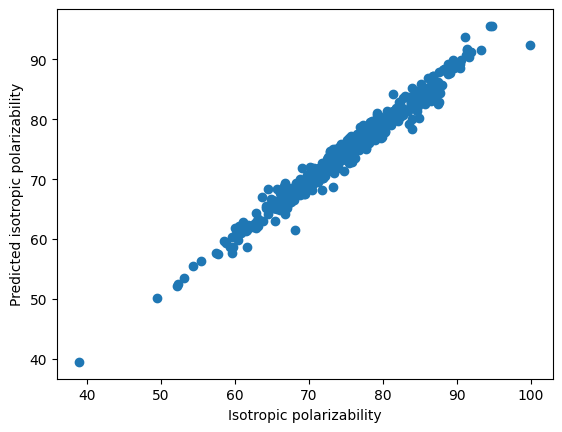

In [ ]:
import matplotlib.pyplot as plt


plt.scatter(real[:500],predictions[:500])
plt.ylabel('Predicted isotropic polarizability')
plt.xlabel('Isotropic polarizability')
#plt.savefig('figures/18_12.png', dpi=300)

## Other GNN layers and recent developments

### Spectral graph convolutions

### Pooling

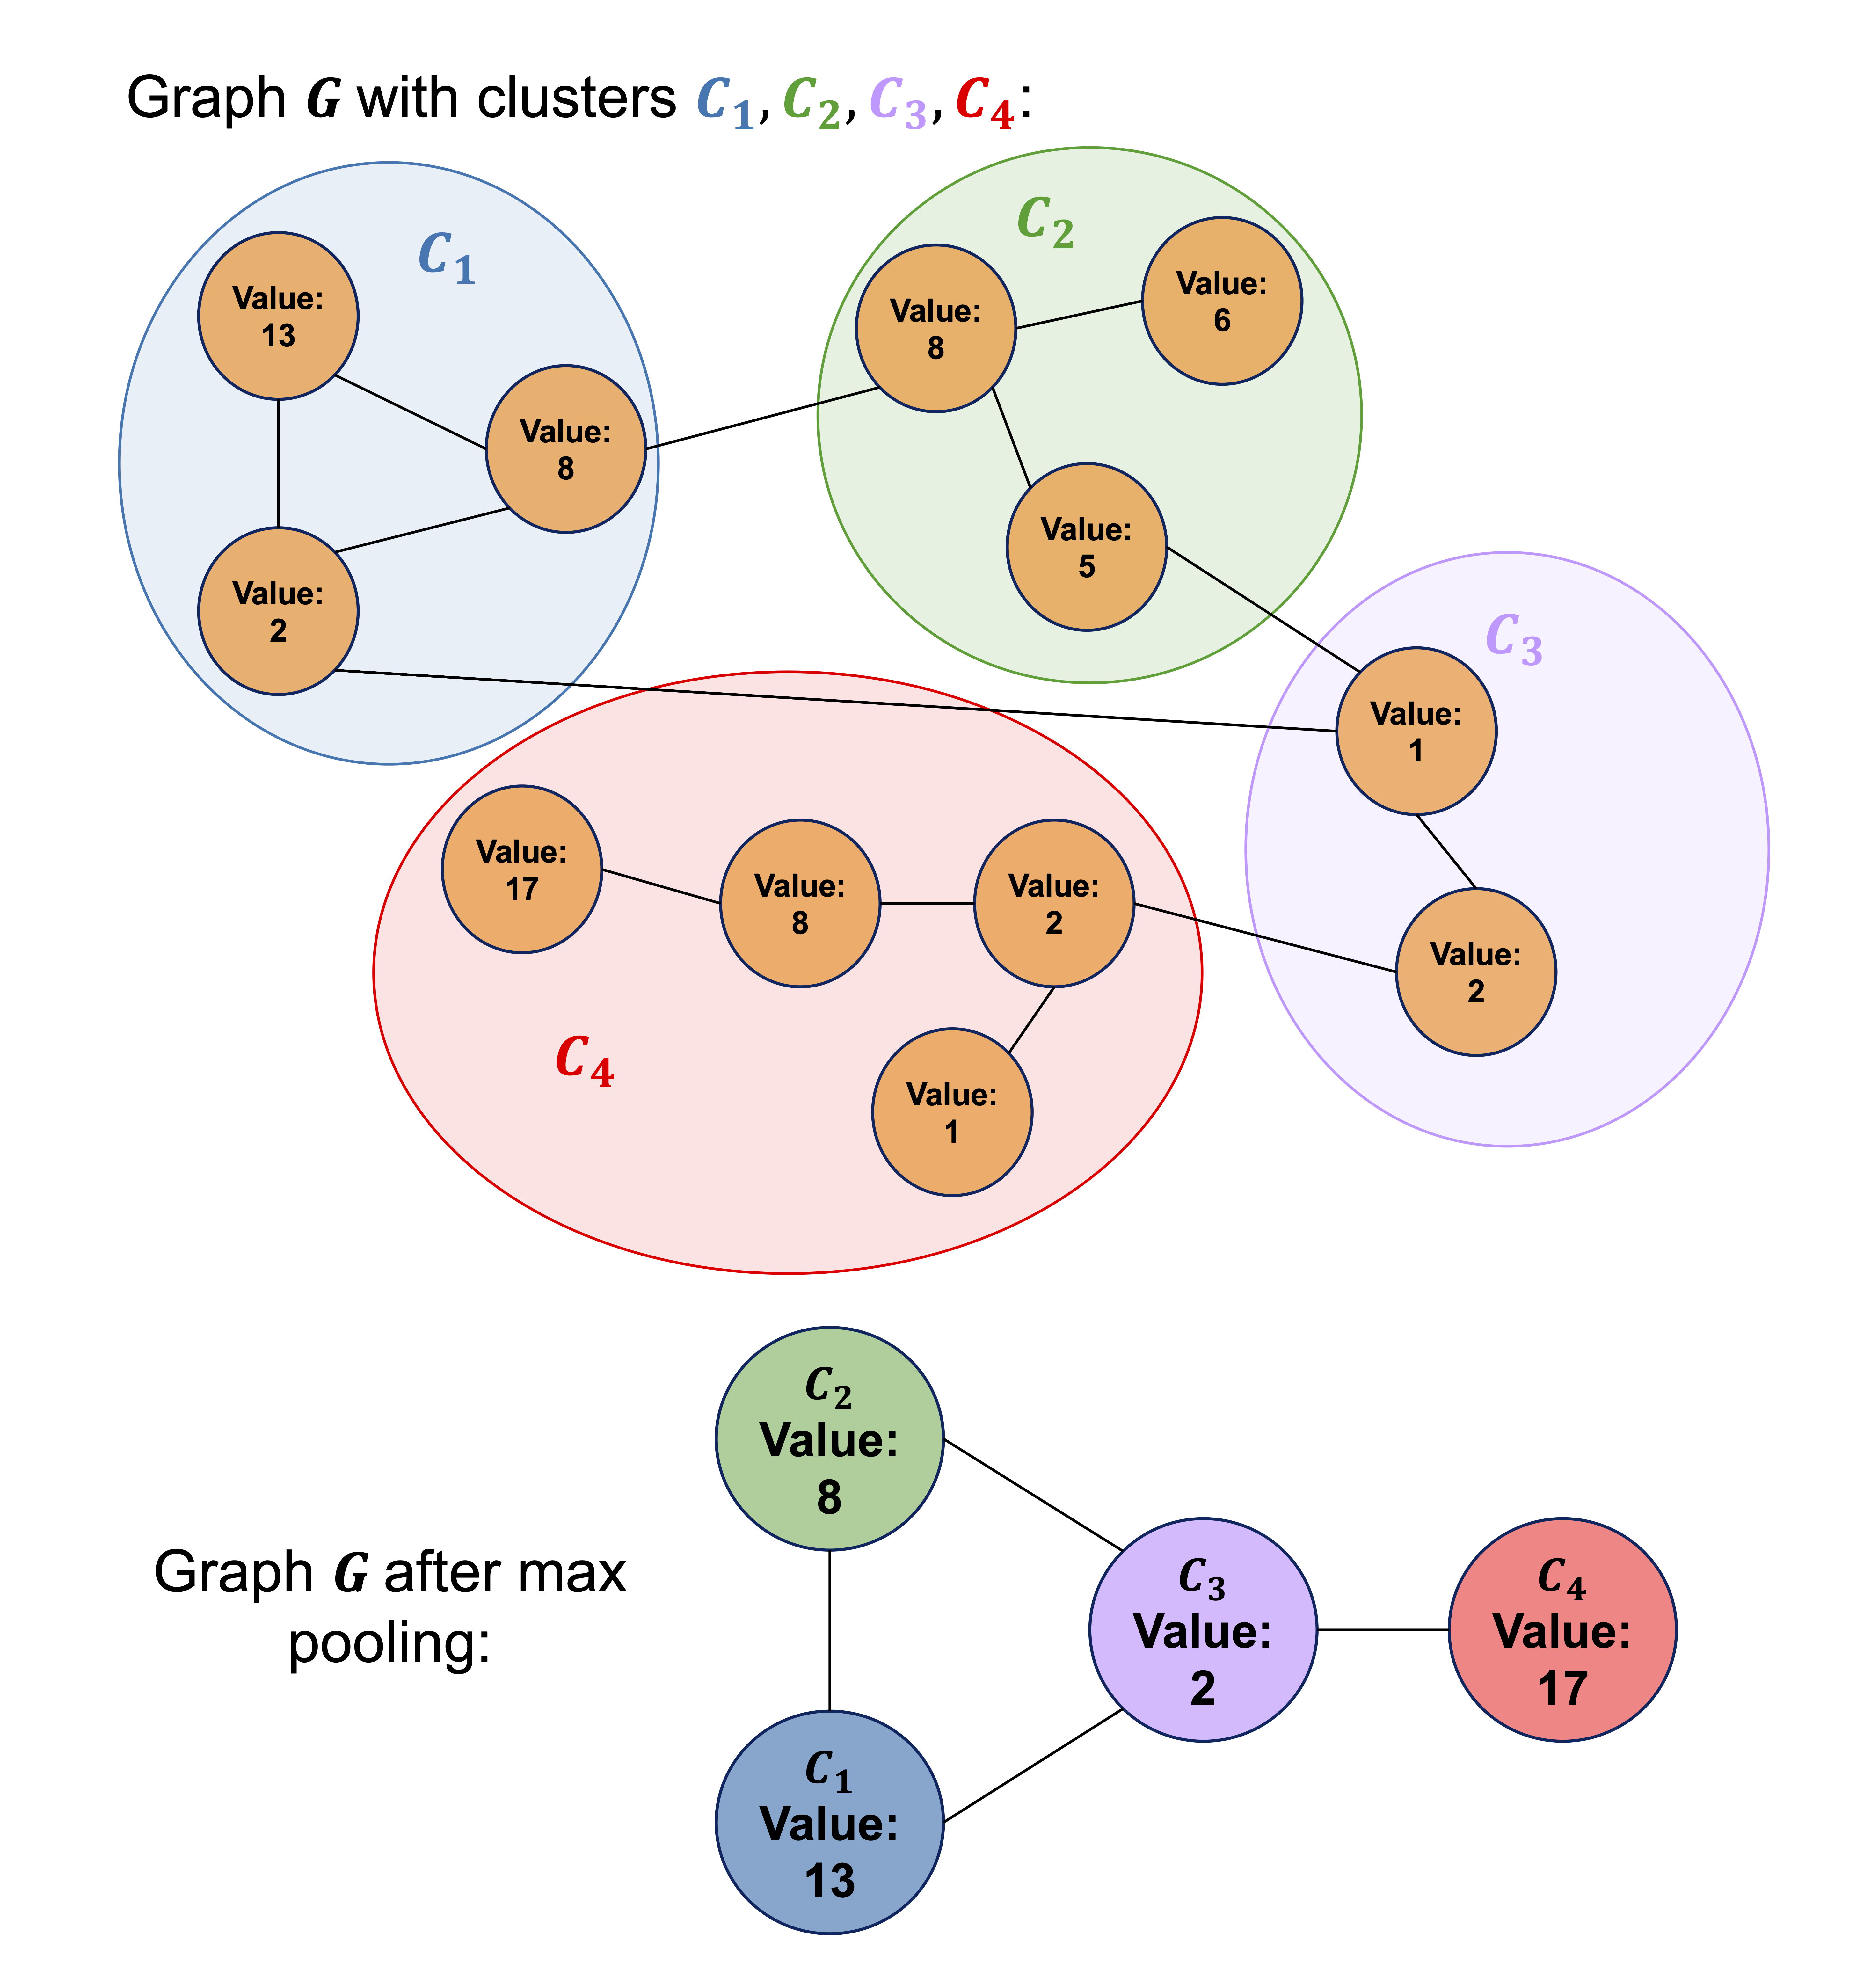

In [ ]:
Image(filename='figures/18_13.png', width=600)

### Normalization

### Pointers to advanced graph neural network literature

## Summary

---

Readers may ignore the next cell.

In [ ]:
! python ../.convert_notebook_to_script.py --input ch18_part2.ipynb --output ch18_part2.py

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook ch18_part2.ipynb to script
[NbConvertApp] Writing 5365 bytes to ch18_part2.py
